# Debug Cluster Changes

This notebook is a utility notebook for examining changes between the current branch and `master`.

## Setup

Libraries:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import dvc.api

## Load Data

We need to load some data files.  We are primarily interested in the book genders.

### Current Book Genders

Load the current genders:

In [2]:
current = pd.read_parquet('book-links/cluster-genders.parquet')
current.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32185879 entries, 0 to 32185878
Data columns (total 2 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   cluster  int32 
 1   gender   object
dtypes: int32(1), object(1)
memory usage: 368.3+ MB


<AxesSubplot:xlabel='count', ylabel='gender'>

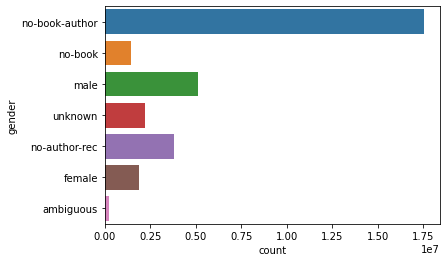

In [3]:
sns.countplot(y='gender', data=current)

In [4]:
current = current.set_index('cluster').sort_index()

### Master Book Genders

Now load the genders from the `master` branch:

In [5]:
with dvc.api.open('book-links/cluster-genders.parquet', rev='master', mode='rb') as pqf:
    master = pd.read_parquet(pqf)
master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32185879 entries, 0 to 32185878
Data columns (total 2 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   cluster  int32 
 1   gender   object
dtypes: int32(1), object(1)
memory usage: 368.3+ MB


In [6]:
master = master.set_index('cluster').sort_index()

### Authors

Let's load book first authors:

In [7]:
authors = pd.read_parquet('book-links/cluster-first-authors.parquet')
authors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23475836 entries, 0 to 23475835
Data columns (total 2 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   cluster      int32 
 1   author_name  object
dtypes: int32(1), object(1)
memory usage: 268.7+ MB


And the author indexes:

In [8]:
cur_au_idx = pd.read_parquet('viaf/author-name-index.parquet')
cur_au_idx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61657282 entries, 0 to 61657281
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   rec_id  uint32
 1   name    object
dtypes: object(1), uint32(1)
memory usage: 705.6+ MB


In [9]:
with dvc.api.open('viaf/author-name-index.parquet', rev='master', mode='rb') as pqf:
    old_au_idx = pd.read_parquet(pqf)
old_au_idx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61681353 entries, 0 to 61681352
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   rec_id  uint32
 1   name    object
dtypes: object(1), uint32(1)
memory usage: 705.9+ MB


## Examine Unmatched Books

Our initial question is to study why we have books without author records matching.

In [10]:
cur_nar_mask = current['gender'] == 'no-author-rec'
cur_nar_mask.describe()

count     32185879
unique           2
top          False
freq      28379752
Name: gender, dtype: object

In [11]:
old_nar_mask = master['gender'] == 'no-author-rec'
old_nar_mask.describe()

count     32185879
unique           2
top          False
freq      28303680
Name: gender, dtype: object

Get the books that are now NAR, but were not before:

In [12]:
newly_nar = cur_nar_mask & ~old_nar_mask
newly_nar.sum()

333336

C:\Users\michaelekstrand\AppData\Local\Temp\ipykernel_9656\2738600571.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.countplot(y='gender', data=master[newly_nar])


<AxesSubplot:xlabel='count', ylabel='gender'>

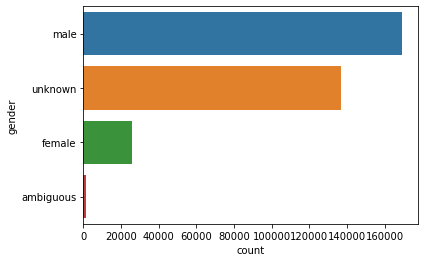

In [13]:
sns.countplot(y='gender', data=master[newly_nar])

Now let's try to look at why. What are these author names?

In [14]:
nnar = master[newly_nar]
nnar_auth = pd.merge(nnar.reset_index(), authors)
nnar_auth.head()

C:\Users\michaelekstrand\AppData\Local\Temp\ipykernel_9656\1737044343.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  nnar = master[newly_nar]


,cluster,gender,author_name
0,100000113,male,J Randall Taraborrelli
1,100000113,male,J Randy Taraborrelli
2,100000113,male,"Taraborrelli, J Randy"
3,100000191,unknown,L M Portnoĭ
4,100000191,unknown,L M Portnoy


What does that look like in current data?

In [15]:
pd.merge(current[newly_nar].reset_index(), authors).head()

C:\Users\michaelekstrand\AppData\Local\Temp\ipykernel_9656\3034751730.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.merge(current[newly_nar].reset_index(), authors).head()


,cluster,gender,author_name
0,100000113,no-author-rec,J Randall Taraborrelli
1,100000113,no-author-rec,J Randy Taraborrelli
2,100000113,no-author-rec,"Taraborrelli, J Randy"
3,100000191,no-author-rec,L M Portnoĭ
4,100000191,no-author-rec,L M Portnoy


Grab that first cluster.

In [16]:
sought = nnar_auth.iloc[:2, 2].tolist()
sought

['J Randall Taraborrelli', 'J Randy Taraborrelli']

Find them in the old data:

In [17]:
matched = old_au_idx[old_au_idx['name'].isin(sought)]
matched

,rec_id,name


What does the current data say for that record?

In [18]:
cur_ver = cur_au_idx[cur_au_idx['rec_id'].isin(matched['rec_id'])].copy()
cur_ver['repr'] = cur_ver['name'].apply(repr)
cur_ver

,rec_id,name,repr
